In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import copy
from IPython.display import clear_output
%matplotlib inline

#### Function to get the maze from a txt file.

In [2]:
def get_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - wall in the maze
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))

    return np.array(m)


#### Define the action space and state space.

In [3]:
#################################
# Action Space
A = [
    (-1, 0),    # 'up'
    (0, 1),     # 'right'
    (0, -1),    # 'left'
    (1, 0),     # 'down'
    (0, 0)      # 'stay'
]
dA = len(A)
#################################
# State Space
S=get_maze('my_maze_10x10.txt')
dS = len(S)
START = (0,0)
GOAL = (dS-1, dS-1)
S[GOAL] = 3
#################################
GAMMA = 0.99 # discount factor
EPSILON = 0.2
LR = 0.1 #learning rate
EPISODE_LENGTH_MAX = 500

DEBUG_MODE = False

#### Function to check if a state is valid.

In [4]:
def validState(s):
    if (min(s) < 0 or max(s) > dS-1) or (S[s] == 1):
        return False
    return True

#### Function to return the reward and the transition probabilities for a given maze.

In [5]:
def BuildMaze(dS, dA, GOAL):

    # dynamics tensor with dimensions: |dS| x |dS| x |dA| x |dS| x |dS| x 1, where the 
    # dimensions are S₁, S₂, A, S₁′, S₂′. e.g., S₂ is the current second coordinate of the state
    # and S₁′ is the first coordinate of the state at the next time step. 
    Ps_sa = np.zeros((dS, dS, dA, dS, dS, 1))

    # the reward tensor with the same dimension as the dynamics
    # reward is -1 on every state, and 0 at the Goal state.
    Rssa = -np.ones((dS, dS, dA, dS, dS, 1))
    
    # Generate the Cartesian indices for the grid
    states = list(itertools.product(range(dS), range(dS)))
    
    # Iterate over the states
    for s in states:
        
        if s == GOAL:
            Ps_sa[s[0], s[1], :, s[0], s[1], :] = 1.0 # can't move once reached the GOAL
            Rssa[s[0], s[1], :, : , :, :] = 0.0  # reward at GOAL is 0
                
        if validState(s) == True:
            
            for a in range(len(A)): 
                s_next = (s[0] + A[a][0], s[1] + A[a][1])
                
                if validState(s_next) == False: # agent hits the wall
                    Rssa[s[0], s[1], a, : , :, :] = -10000
                    s_next = s
                    
                Ps_sa[s[0], s[1], a, s_next[0], s_next[1], :] = 1.0 
                
        if validState(s) == False:
            Ps_sa[s[0], s[1], :, s[0], s[1], :] = 0.0 # can't penetrate through the wall
            #Rssa[s[0], s[1], :, : , :, :] = -10000  # reward at wall is -10000
            
                         
    # Sanity test: For all a and s, sum_s′ Ps′_sa = 1
    #print(np.sum(Ps_sa, axis=(3, 4), keepdims=True))
    #sanity_check = np.allclose(np.sum(Ps_sa, axis=(3, 4), keepdims=True), np.ones((dS, dS, dA)))
    #print(sanity_check)
    #input()

    return Ps_sa, Rssa


#### Function to plot a policy and the value of that policy.

In [6]:
def plot_value_grid(V, policy, msg=""):
    V = np.reshape(V,(dS,dS))
    #print(V.shape)
    fig = plt.figure(figsize=(4, 4), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
   
    quiver_action_dict = [
        (0, 1),     # up arrow
        (1, 0),     # right arrow
        (-1, 0),    # left arrow
        (0, -1),    # down arrow
        (0, 0)      # no arrows
    ]
    
    for k, _ in np.ndenumerate(policy):
        if(S[k[0],k[1]] == 0): # don't draw arrows on the walls
            a = np.argmax(policy[k[0],k[1],:].flatten())
            q = plt.quiver(k[1], k[0], quiver_action_dict[a][0], quiver_action_dict[a][1], color='w')
            
    #fig.colorbar(q)
    #plt.show()
    

#### Policy Evaluation (PE) algorithm.

In [7]:
def policy_evaluation(POLa_s, Ps_sa, Rssa, discount=GAMMA, ctr=100):
# find the value of each state for a given policy
    
    theta = 1e-6
    
    V = np.zeros((dS, dS, 1, 1, 1, 1))
    V_prev = np.zeros((1, 1, 1, dS, dS, 1))

    R = np.sum(POLa_s*np.sum(Ps_sa*Rssa, axis=(3,4), keepdims=True), axis=2, keepdims=True)
    
    for i in range(ctr):
        
        delta = 0
        V_prev = np.transpose(V, axes=(3,4,5,0,1,2))
        V = R + discount*np.sum(POLa_s*np.sum(Ps_sa*V_prev, axis=(3,4), keepdims=True), axis=2, keepdims=True)
        
        #print(V[7,7].flatten())
        
        V_prev = np.transpose(V_prev, axes=(3,4,5,0,1,2))
        delta = max(delta, np.max(abs(V - V_prev)))
        
        if delta < theta: break
            
    return V, delta

        

#### Policy Improvement (PI) algorithm.

In [8]:
def policy_improvement(oldPOLa_s, V, Ps_sa, discount=GAMMA):
    
    POLa_s = np.zeros((dS, dS, dA, 1, 1, 1))
    Qsa = np.zeros((dS, dS, dA, 1, 1, 1))
    policy_stable = False
    
    Rsa = np.sum(Ps_sa*Rssa, axis=(3,4), keepdims=True)
    
    Qsa = Rsa + discount*np.sum(Ps_sa*np.transpose(V, axes=(3,4,5,0,1,2)), axis=(3,4), keepdims=True)
    
    argmax_indices = np.argmax(Qsa, axis=2)
    
    # Optimal policy
    for i in range(dS):
        for j in range(dS):
            a = argmax_indices[i,j]
            POLa_s[i,j,a] = 1
   
    if np.allclose(POLa_s, oldPOLa_s) == True: policy_stable = True
    
    return POLa_s, policy_stable

#### Policy Iteration (PIter) algorithm.

In [9]:
def policy_iteration(Ps_sa, discount=1, plot=None):
   
    POLa_s = np.zeros((dS, dS, dA, 1, 1, 1))
    POLa_s[:,:,0] = 1 # start with policy = up in all states        
    
    count=0
    while True:
        
        V, delta = policy_evaluation(POLa_s, Ps_sa, Rssa) 
        POLa_s, policy_stable = policy_improvement(POLa_s, V, Ps_sa)

        # plot current value and optimal policy
        if plot and count+1 in plot or delta==0:
            plot_value_grid(V, POLa_s, msg='Policy iteration {}'.format(count+1))
        if delta<=0 or count==99 or policy_stable:  
            break
        count=count+1
        
    return V, POLa_s


#### Write a function, s′, r = step(s, a), that receives the current state, s, and the current action, a, and returns the next state, s′, and reward, r.

In [10]:
def step(s, a):
    
    r = -1
    
    if s == GOAL:
        s_next = s # can't move once reached the GOAL
        r = 0 # reward at GOAL is 0
         
    if validState(s) == True:
        s_next = (s[0] + A[a][0], s[1] + A[a][1])
        if validState(s_next) == False: # agent hits the wall
            s_next = s  
            r = -100
                    
    elif validState(s) == False:
        s_next = s # can't penetrate through the wall
        
    return s_next, r
         

#### Model-free learning.


In [11]:
def choose_action_epsilon(Q, s, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, len(A)-1)  # exploration (if random number < epsilon)
    return np.argmax(Q[s[0], s[1], :])      # exploitation (if random number > epsilon)

In [12]:
def plot_policy_from_qtable(Q, msg=""):
    '''This function plots the policy learned from Q-Learning
    :param Q: Q-table
    '''
    plt.figure(figsize=(4, 4), tight_layout=True)
    plt.title(msg)
    policy = np.argmax(Q, axis=2)
    ax = plt.gca()
    ax.set_xticks(np.arange(0, dS, 1))
    ax.set_yticks(np.arange(0, dS, 1))
    ax.set_xticks(np.arange(-.5, dS, 1), minor=True)
    ax.set_yticks(np.arange(-.5, dS, 1), minor=True)
    plt.imshow(np.max(Q, axis=2).reshape(dS,dS))
    quiver_action_dict = [
        (0, 1),     # up arrow
        (1, 0),     # right arrow
        (-1, 0),    # left arrow
        (0, -1),    # down arrow
        (0, 0)      # no arrows
    ]
    for k, v in np.ndenumerate(policy):
        if(S[k] == 0): # do not print the arrows on walls, to increase readibility 
            plt.quiver(k[1], k[0] , quiver_action_dict[v][0], quiver_action_dict[v][1], color='w')
    plt.show()

In [13]:
def model_free(algorithm_type, discount, episodes, show=True):
    '''
    : param algorithm_type: Select between 'Q-learning' or 'SARSA'
    : param discount: Discount factor
    : param episodes: Number of episodes to be run
    '''
        
    plt.ion()

    # Q - Table
    Q = np.zeros((dS, dS, len(A)))

    # q-table check points
    Qs = []
       
    r_list = []
    sum_steps = 0
    for episode in range(episodes):
        if episode<500: 
            s = (np.random.randint(0, dS), np.random.randint(0, dS))
            while S[s] != 0: # don't let the agent start an episode on a wall
                s = (np.random.randint(0, dS), np.random.randint(0, dS))
        else:
            s=START
        r_sum = 0
        i = 1
        
        if algorithm_type == 'Q-learning': #############################################################
            
            while s != GOAL and i < EPISODE_LENGTH_MAX:
                # Choose A from S using epsilon-greedy policy
                a = choose_action_epsilon(Q, s, EPSILON)
                # Take action A, observe R, S'
                s_next, r = step(s,a)
                # Find the qvalue for the next state 
                q_next = np.max(Q[s_next[0]][s_next[1]][:]) # Assume a greedy policy for a_next
                # Update Q table
                Q[s[0]][s[1]][a] = (1-LR)*Q[s[0]][s[1]][a] + LR*(r + discount*q_next)
                #update current state with next state
                s = s_next
                #add the current reward with accumulated reward
                r_sum = r_sum + r
                #increment the Episode count by one
                i = i+1
                
        elif algorithm_type == 'SARSA': #############################################################
            
            # Choose A from S using epsilon-greedy policy
            a = choose_action_epsilon(Q, s, EPSILON)
            
            while s != GOAL and i < EPISODE_LENGTH_MAX:
                # Take action A, observe R, S'
                s_next, r = step(s,a)
                # Find the qvalue for the next state 
                a_next = choose_action_epsilon(Q, s_next, EPSILON) # Assume a epsilon-greedy policy for a_next
                q_next = Q[s_next[0]][s_next[1]][a_next] 
                # Update Q table
                Q[s[0]][s[1]][a] = (1-LR)*Q[s[0]][s[1]][a] + LR*(r + discount*q_next)
                #update current state with next state
                s = s_next
                #update current action with next action
                a = a_next
                #add the current reward with accumulated reward
                r_sum = r_sum + r
                #increment the Episode count by one
                i = i+1
            
        
        #increment the sum_step with the Episode count

        sum_steps = sum_steps + i
        r_list.append(r_sum)
        if show:
            if (episode+1) % 10 == 0:
                clear_output(wait=True)
                plot_policy_from_qtable(Q, msg="Episode: {}".format(episode+1))

            if (episode+1) % (episodes//5) == 0:
                Qs.append(copy.deepcopy(Q))
    
    if show:
        clear_output(wait=True)
        for i, q in enumerate(Qs):
            plot_policy_from_qtable(q, msg="Episode: {}".format((1+i)*(episodes//5)))
            
    if DEBUG_MODE == True:
        # write Q table on a txt file
        with open('result.txt', 'w') as f:
            for x in range(dS):
                for y in range(dS):
                    f.write("s(%s , %s) " % (x, y))
                    for ai in range(5):
                        f.write(" %s" % Q[x][y][ai])
                    f.write('\n')

            
    return r_list



### Task 1 ###
Build your maze with dimensions 10x10 and 3 fences, and the goal state (exit)
in one of the corners of the maze. Visualize the maze layout on 2D plot.

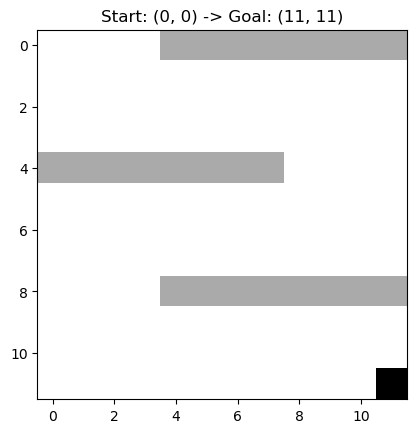

In [14]:
# Build the maze
Ps_sa, Rssa = BuildMaze(dS, dA, GOAL)

# Visualize the maze
plt.title("Start: {} -> Goal: {}" .format(START, GOAL))
plt.imshow(S, cmap='binary')

### Task 2 ###
Implement the Policy Evaluation (PE) algorithm for a deterministic policy, π. Evaluate a random deterministic policy, π.  Plot Value of a random policy on 2D plot. 

#### Create a random deterministic policy.

/Users/ezgikaya/miniconda3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/quiver.py:658: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/ezgikaya/miniconda3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/quiver.py:658: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


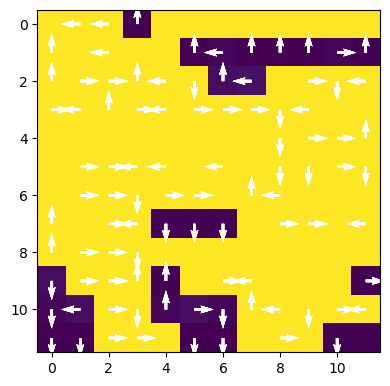

In [15]:
# Create a random deterministic policy 
POLa_s = np.zeros((dS, dS, dA, 1, 1, 1))
for i in range(dS):
    for j in range(dS):
        a = random.randint(0, 4)
        POLa_s[i,j,a,:,:,:] = 1

# Evaluate the policy and plot Value
V, delta = policy_evaluation(POLa_s, Ps_sa, Rssa) 
plot_value_grid(V, POLa_s)


### Task 3 ###
Repeat Task 2 with manually setting the optimal actions in the radius of 2 states from the goal state.
Explain your observations.

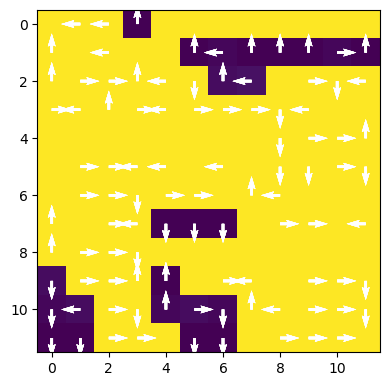

In [16]:
# Manually set the optimal actions in the radius of 2 states from the goal state

POLa_s[dS-3, dS-3, :, :, :, :] = 0
POLa_s[dS-3, dS-2, :, :, :, :] = 0
POLa_s[dS-3, dS-1, :, :, :, :] = 0
POLa_s[dS-2, dS-3, :, :, :, :] = 0
POLa_s[dS-2, dS-2, :, :, :, :] = 0
POLa_s[dS-2, dS-1, :, :, :, :] = 0
POLa_s[dS-1, dS-3, :, :, :, :] = 0
POLa_s[dS-1, dS-2, :, :, :, :] = 0
POLa_s[dS-1, dS-1, :, :, :, :] = 0

POLa_s[dS-3, dS-3, 1, :, :, :] = 1
POLa_s[dS-3, dS-2, 1, :, :, :] = 1
POLa_s[dS-3, dS-1, 3, :, :, :] = 1
POLa_s[dS-2, dS-3, 1, :, :, :] = 1
POLa_s[dS-2, dS-2, 1, :, :, :] = 1
POLa_s[dS-2, dS-1, 3, :, :, :] = 1
POLa_s[dS-1, dS-3, 1, :, :, :] = 1
POLa_s[dS-1, dS-2, 1, :, :, :] = 1
POLa_s[dS-1, dS-1, 4, :, :, :] = 1

# Evaluate the policy and plot Value
V, delta = policy_evaluation(POLa_s, Ps_sa, Rssa) 
plot_value_grid(V, POLa_s)

#### Observations:

### Task 4 ###
Implement the Policy Improvement (PI) Algorithm, and find the optimal policy π*.
Visualize the optimal value function, $V_i$, on a 2D plot at 3 different iterations, i, of PI.
Explain your observations.

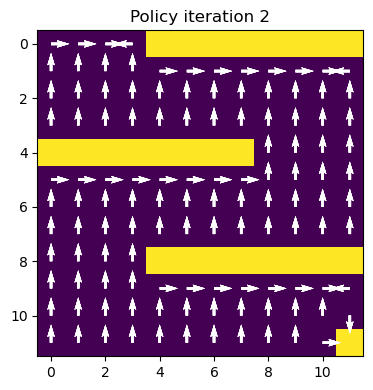

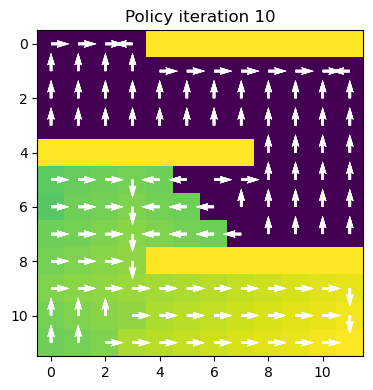

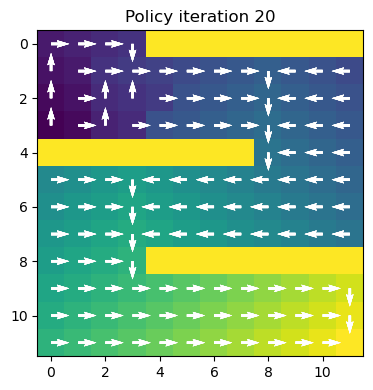

In [17]:
opt_V, opt_policy = policy_iteration(Ps_sa, discount=GAMMA, plot=[2, 10])

#### Observations:

### Task 5 ###
Generate 10 trajectories from 10 different initial states, using a random policy.
Generate 10 trajectories from 10 different initial states, using the optimal policy from Task 4 above.
Explain your observations.

In [18]:

print('Using the random policy from Task 3:\n')

for t in range(10):
    states = list(itertools.product(range(dS), range(dS)))
    valid_states = filter(validState, states)
    s_init = random.choice(list(valid_states))
    s = s_init
    r_sum = 0
    i = 0

    while s != GOAL and i < EPISODE_LENGTH_MAX:
        # Determine the action using a random policy
        a = np.argmax(POLa_s[s[0],s[1],:].flatten())
        # Take action A, observe R, S'
        s_next, r = step(s,a)
        #update current state with next state
        s = s_next
        #add the current reward with accumulated reward
        r_sum = r_sum + r
        #increment the Episode count by one
        i = i+1
        

    print("Trajectory {} -> s_init: {}, accumulated reward: {} " .format(t, s_init, r_sum))
    
    
print('\nUsing the optimal policy from Task 4:\n')

for i in range(10):
    states = list(itertools.product(range(dS), range(dS)))
    valid_states = filter(validState, states)
    s_init = random.choice(list(valid_states))
    s = s_init
    r_sum = 0
    i = 0

    while s != GOAL and i < EPISODE_LENGTH_MAX:
        # Determine the action using a random policy
        a = np.argmax(opt_policy[s[0],s[1],:].flatten())
        # Take action A, observe R, S'
        s_next, r = step(s,a)
        #update current state with next state
        s = s_next
        #add the current reward with accumulated reward
        r_sum = r_sum + r
        #increment the Episode count by one
        i = i+1
        

    print("Trajectory {} -> s_init: {}, accumulated reward: {} " .format(t, s_init, r_sum))
    


Using the random policy from Task 3:

Trajectory 0 -> s_init: (2, 2), accumulated reward: -500 
Trajectory 1 -> s_init: (3, 3), accumulated reward: -500 
Trajectory 2 -> s_init: (3, 6), accumulated reward: -500 
Trajectory 3 -> s_init: (7, 4), accumulated reward: -50000 
Trajectory 4 -> s_init: (5, 2), accumulated reward: -500 
Trajectory 5 -> s_init: (2, 8), accumulated reward: -500 
Trajectory 6 -> s_init: (6, 8), accumulated reward: -500 
Trajectory 7 -> s_init: (7, 3), accumulated reward: -500 
Trajectory 8 -> s_init: (2, 1), accumulated reward: -500 
Trajectory 9 -> s_init: (8, 0), accumulated reward: -500 

Using the optimal policy from Task 4:

Trajectory 9 -> s_init: (6, 9), accumulated reward: -19 
Trajectory 9 -> s_init: (7, 7), accumulated reward: -16 
Trajectory 9 -> s_init: (7, 0), accumulated reward: -15 
Trajectory 9 -> s_init: (1, 0), accumulated reward: -33 
Trajectory 9 -> s_init: (10, 10), accumulated reward: -2 
Trajectory 9 -> s_init: (5, 7), accumulated reward: -1

#### Observations:

### Task 5.2 ###
Implement Q-learning algorithm for the tabular case, where Q function is given by a table. 
Plot an accumulated reward as a function of the iteration number of Q-learning algorithm 
for 5 runs of Q-learning from scratch. Plot an average curve of the 4 runs of Q-learning, 
and the variance (use fill_between). Explain your observations

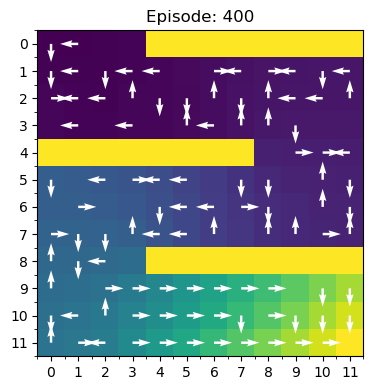

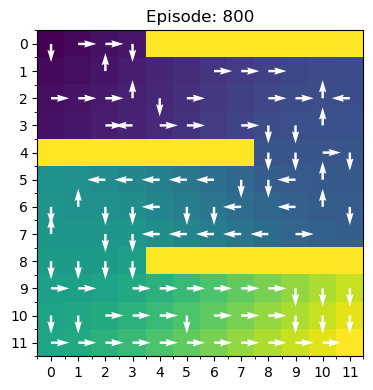

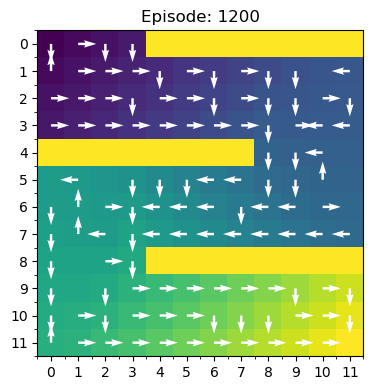

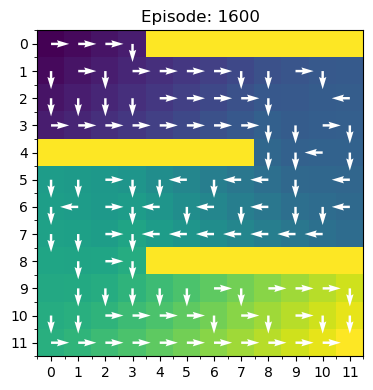

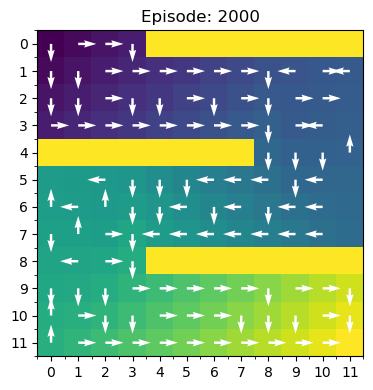

In [19]:
# Run Q-learning algorithm 
eps = 2000 #epochs
r_list = model_free('Q-learning', GAMMA , eps)

Text(0.5, 0, 'Episodes')

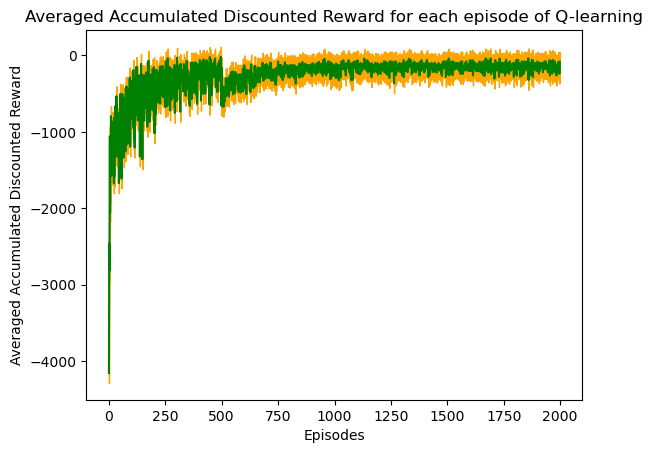

In [20]:
steps = 2000
numberOfSeeds=5
a_rewards=[]
for i in range(numberOfSeeds):
    a_rewards.append(model_free('Q-learning', GAMMA, steps, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)

a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode of Q-learning")
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")
#plt.ylim([-7000, 1000])



#### Observations

### Task 6 ###
Repeat Task 5 with the SARSA Algorithm.
Explain your observations.

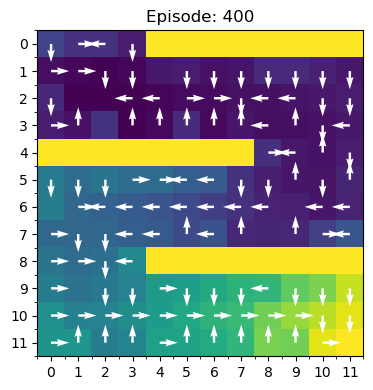

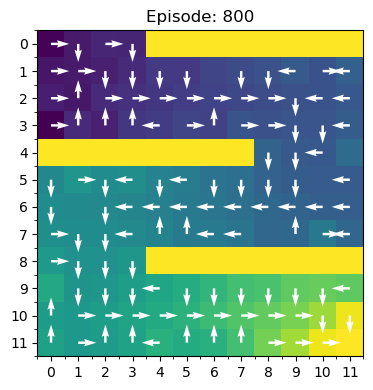

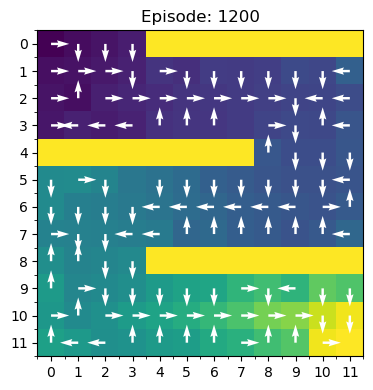

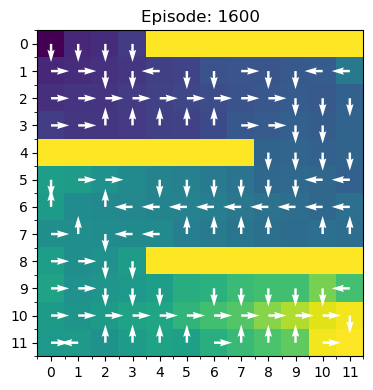

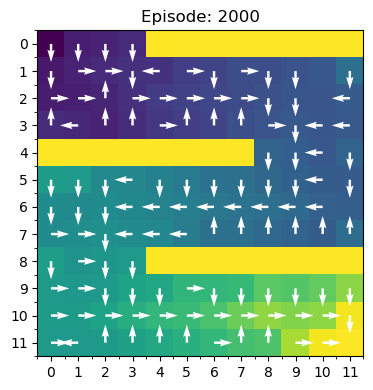

In [21]:
# Run SARSA algorithm 
eps = 2000 #epochs
r_list = model_free('SARSA', GAMMA , eps)

Text(0.5, 0, 'Episodes')

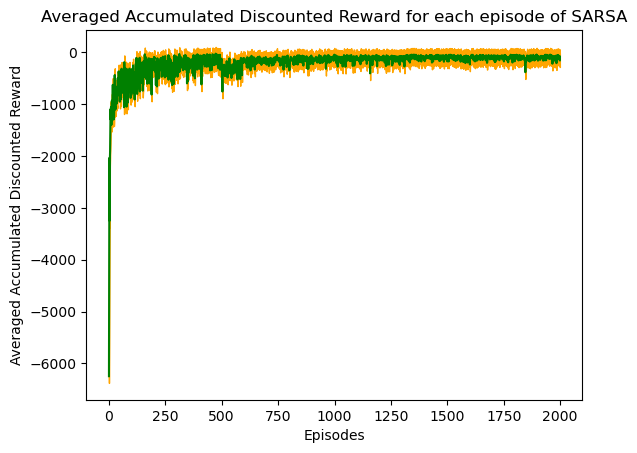

In [22]:
steps = 2000
numberOfSeeds=5
a_rewards=[]
for i in range(numberOfSeeds):
    a_rewards.append(model_free('SARSA', GAMMA, steps, show=False))
a_rewards=np.array(a_rewards)
a_rewards1=np.average(a_rewards, axis=0)
sd=np.std(a_rewards1)

a=a_rewards1+0.5*sd
b=a_rewards1-0.5*sd
#print(len(a),len(b))
plt.fill_between(range(len(a)), a, b, color='orange')
plt.plot(a_rewards1, color="green")
plt.title("Averaged Accumulated Discounted Reward for each episode of SARSA")
plt.ylabel("Averaged Accumulated Discounted Reward")
plt.xlabel("Episodes")
#plt.ylim([-7000, 1000])


#### Observations